In [60]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [61]:
import geopandas as gpd
from shapely.geometry import Polygon
from shapely import wkt
from shapely import wkb
from fiona.crs import from_epsg
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.dates import DateFormatter
import matplotlib.patches as mpatches

from sentinelsat import SentinelAPI
import pandas as pd
from datetime import datetime
from datetime import date
import glob
from collections import OrderedDict
import os
import csv
import random

import numpy as np

import requests
import json
import getpass

from tqdm import tqdm
from google.cloud import storage

from utils.prep_utils import s3_list_objects_paths, s3_list_objects, s3_download, s3_upload_cogs, create_yaml, get_geometry
from utils.prepS1 import get_s1_asf_urls


In [62]:
def get_s2_csvfile(gc_path, loc_path):

    client = storage.Client.create_anonymous_client()
    bucket = client.bucket(bucket_name="gcp-public-data-sentinel-2", user_project=None)

    blobs = bucket.list_blobs(prefix=gc_path)  # Get list of files
    blob = [i for i in blobs][0]
    
    blob.download_to_filename(loc_path)

- speed up world tiles querying by inverting search
- speed up gcloud zipped csvs by parallelising(?)
- convert into functions/tools rather than nb


# **INPUTS**

In [63]:
# req
region = 'Fiji' # any country name OR wkt in epsg 3426
# region = 'POLYGON((177.44 -17.52,177.65 -17.52,177.65 -17.73,177.44 -17.73,177.44 -17.52))'
fiji_am = True

update_acqs_s2_gcloud = False
update_acqs_ls_usgs = False

# **VARS**

In [64]:
# deafult
inter_dir = '/tmp/data/' # local directory for any processing and outputs
# products = {
#     'SENTINEL_1':{
#         'PRODUCTS':['GRD'],
#         'SOURCES':['ESAHUB','ASF']
#     },
#     'SENTINEL_2':{
#         'PRODUCTS':['L2A'],
#         'SOURCES':['ESAHUB','GCLOUD']
#     },
#     'LANDSAT_8':{
#         'PRODUCTS'['L1'],
#         'SOURCES':['USGS']
#     },
#     'LANDSAT_7':{
#         'PRODUCTS'['L1'],
#         'SOURCES':['USGS']
#     },
#     'LANDSAT_5':{
#         'PRODUCTS'['L1'],
#         'SOURCES':['USGS']
#     },
#     'LANDSAT_4':{
#         'PRODUCTS'['L1'],
#         'SOURCES':['USGS']
#     }
# }
# outputs = ['csvs','shp','granule_maps','temporal_plots']

# optional
upload = False # if False then below can be ignored
s3_bucket = 'public-eo-data'
jobs_s3dir = 'common_sensing/tom/dataprep_jobs/'

In [65]:
if fiji_am:
    plot_crs = {"init": "epsg:3460"}
else:
    plot_crs = {"init": "epsg:4326"}

In [66]:
os.makedirs(f'{inter_dir}ancillary', exist_ok=True)
os.makedirs(f'{inter_dir}outputs', exist_ok=True)

# **Check Req Envs**

In [67]:
source_envars = {
    'ESAHUB':['COPERNICUS_USERNAME','COPERNICUS_PWD'],
    'ASF':['ASF_USERNAME','ASF_PWD'],
    'USGS':['USGS_USERNAME','USGS_PWD']
}

In [68]:
for envars in source_envars:
    for var in source_envars[envars]:
        print(var,':',os.getenv(var)!=None)

COPERNICUS_USERNAME : True
COPERNICUS_PWD : True
ASF_USERNAME : True
ASF_PWD : True
USGS_USERNAME : True
USGS_PWD : True


# **Download any necessary AoI Vectors and Ancillary datasets**

In [69]:
# local paths
anc_dir = f'{inter_dir}ancillary/'
anc_dir_rem = 'common_sensing/ancillary_products/'
anc_paths = {
    's2tiles_path': [f'{anc_dir}sentinel2_tiles_world.geojson',f'{anc_dir_rem}SatelliteSceneTiles/sentinel2_tiles_world/sentinel2_tiles_world.geojson'],
    'lstiles_path': [f'{anc_dir}WRS2_descending.geojson',f'{anc_dir_rem}SatelliteSceneTiles/landsat_pr/WRS2_descending.geojson'],
    'wborders_path': [f'{anc_dir}TM_WORLD_BORDERS.geojson',f'{anc_dir_rem}TM_WORLD_BORDERS/TM_WORLD_BORDERS.geojson'],
    's2l1csv_path': [f'{anc_dir}L1_index.csv.gz','index.csv.gz'],
    's2l2csv_path': [f'{anc_dir}L2_index.csv.gz','L2/index.csv.gz'],
    'ls8csv_path': [f'{anc_dir}LANDSAT_8_C1_new.csv.gz','https://landsat.usgs.gov/landsat/metadata_service/bulk_metadata_files/LANDSAT_8_C1.csv.gz'],
    'ls7csv_path': [f'{anc_dir}LANDSAT_7_C1_new.csv.gz','https://landsat.usgs.gov/landsat/metadata_service/bulk_metadata_files/LANDSAT_ETM_C1.csv.gz'],
    'ls45csv_path': [f'{anc_dir}LANDSAT_45_C1_new.csv.gz','https://landsat.usgs.gov/landsat/metadata_service/bulk_metadata_files/LANDSAT_TM_C1.csv.gz'],
    'ls12csv_path': [f'{anc_dir}LANDSAT_12_C1_new.csv.gz','https://landsat.usgs.gov/landsat/metadata_service/bulk_metadata_files/LANDSAT_MSS_C1.csv.gz']
}

In [70]:
loc_anc_exists = dict(zip(anc_paths.keys(), [os.path.exists(anc_paths[i][0]) for i in anc_paths]))
print(loc_anc_exists)

{'s2tiles_path': True, 'lstiles_path': True, 'wborders_path': True, 's2l1csv_path': True, 's2l2csv_path': True, 'ls8csv_path': True, 'ls7csv_path': True, 'ls45csv_path': True, 'ls12csv_path': True}


In [71]:
%%time
# get fixed anc files
fixed_ancs = ['s2tiles_path','lstiles_path','wborders_path']
for f in tqdm(fixed_ancs):
    if os.path.exists(anc_paths[f][0]) == False:
        print(f'Downloading {anc_paths[f][1]}')
        s3_download(s3_bucket, anc_paths[f][1], anc_paths[f][0])
        print(f'Downloaded {anc_paths[f][1]}')        
    else:
        print(f'{anc_paths[f][0]} already available')
        
# get variable anc files if unavailable or need to be updated
var_ancs_gc = ['s2l1csv_path','s2l2csv_path']
for f in tqdm(var_ancs_gc):    
    if (os.path.exists(anc_paths[f][0]) == False) | (update_acqs_s2_gcloud == True):
        print(f'Downloading {anc_paths[f][1]}')
        get_s2_csvfile(anc_paths[f][1], anc_paths[f][0])
        print(f'Downloaded {anc_paths[f][1]}')
    else:
        print(f'{anc_paths[f][0]} already available')
var_ancs_urls = ['ls8csv_path','ls7csv_path','ls45csv_path','ls12csv_path']
for f in tqdm(var_ancs_urls):
    if (os.path.exists(anc_paths[f][0]) == False) | (update_acqs_ls_usgs == True):
        print(f'Downloading {anc_paths[f][1]}')
        open(f'{anc_paths[f][0]}', 'wb').write(requests.get(anc_paths[f][1]).content)
        print(f'Downloaded {anc_paths[f][1]}')
    else:
        print(f'{anc_paths[f][0]} already available')



100%|██████████| 3/3 [00:00<00:00, 4653.44it/s]


100%|██████████| 2/2 [00:00<00:00, 2694.70it/s]


100%|██████████| 4/4 [00:00<00:00, 5011.12it/s]

/tmp/data/ancillary/sentinel2_tiles_world.geojson already available
/tmp/data/ancillary/WRS2_descending.geojson already available
/tmp/data/ancillary/TM_WORLD_BORDERS.geojson already available
/tmp/data/ancillary/L1_index.csv.gz already available
/tmp/data/ancillary/L2_index.csv.gz already available
/tmp/data/ancillary/LANDSAT_8_C1_new.csv.gz already available
/tmp/data/ancillary/LANDSAT_7_C1_new.csv.gz already available
/tmp/data/ancillary/LANDSAT_45_C1_new.csv.gz already available
/tmp/data/ancillary/LANDSAT_12_C1_new.csv.gz already available
CPU times: user 20.4 ms, sys: 8.1 ms, total: 28.5 ms
Wall time: 21.1 ms


# **CREATE AOI**

POLYGON ((176.9523476175718 -20.68381436713493, -178.1818159642579 -20.6658807815134, -178.3092093155264 -12.47122966420926, 177.0270856916581 -12.48175579552153, 176.9523476175718 -20.68381436713493))


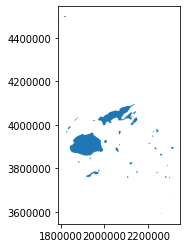

In [72]:
world_borders = gpd.read_file(anc_paths['wborders_path'][0])
if region in world_borders.NAME.values:
    aoi = world_borders.loc[world_borders.NAME == region]
    region_name = region
else:
    aoi = pd.DataFrame(data={'geometry': [region]})
    aoi['geometry'] = aoi['geometry'].apply(wkt.loads)
    aoi = gpd.GeoDataFrame(aoi, geometry='geometry', crs=('epsg:4326'))
    aoi['NAME'] = 'RegionName'
    region_name = 'RegionName'
aoi_wkt = aoi.to_crs(plot_crs).envelope.to_crs({"init": "epsg:4326"}).values[0].wkt
print(aoi_wkt)
aoi.to_crs(plot_crs).plot();

# **SENTINEL_2**

### DETERMINE OVERLAPPING GRANULES

In [73]:
# load world granules
world_granules = gpd.read_file(anc_paths['s2tiles_path'][0])
# Create bool for intersection between any tiles - should try inversion to speed up...
for n, g in zip(aoi.NAME, aoi.geometry):
    world_granules[n] = world_granules.geometry.apply(lambda x: gpd.GeoSeries(x).intersects(g))
# Filter based on any True intersections
world_granules[region_name] = world_granules[world_granules[aoi.NAME.values]].any(1)
region_s2_grans = world_granules[world_granules[region_name]==True]

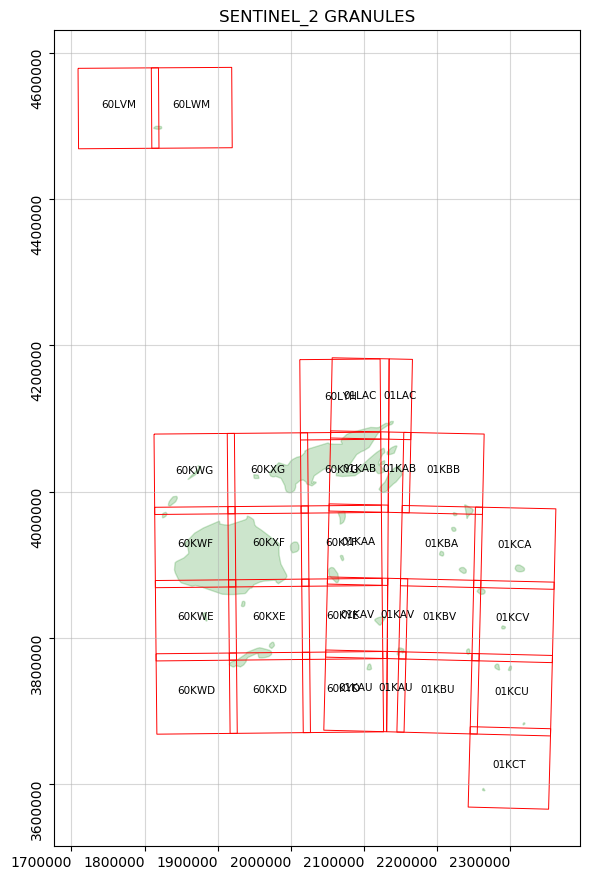

In [74]:
# Plot coverage
fig, ax = plt.subplots(figsize=(12,12),dpi=100)
fig.autofmt_xdate()
leg_patches=[]

x = aoi.to_crs(plot_crs).plot(facecolor="g", edgecolor='g', ax=ax, alpha=0.2);
leg_patches.append(mpatches.Patch(facecolor="g", edgecolor='g', alpha=0.25, lw=0.7, label=region_name))

x = region_s2_grans.to_crs(plot_crs).plot(facecolor="none", edgecolor='r', lw=0.7, ax=ax)
leg_patches.append(mpatches.Patch(facecolor="none", edgecolor='r', lw=0.7, label='Sentinel-2 Tiles'))
region_s2_grans.to_crs(plot_crs).apply(lambda x: ax.annotate(s=x.Name, xy=x.geometry.centroid.coords[0], ha='center', fontsize=7.5),axis=1)

ax.set_title('SENTINEL_2 GRANULES')
ax.grid(alpha=0.5);
ax.tick_params(axis='y', rotation=90);
ax.tick_params(axis='x', rotation=0);

### ESA QUERY

In [75]:
# Login to esa api
esa_api = SentinelAPI(os.environ['COPERNICUS_USERNAME'],os.environ['COPERNICUS_PWD'])

In [76]:
# l2a results
res = esa_api.query(aoi_wkt, platformname='Sentinel-2',producttype='S2MSI2A')
esa_l2a = esa_api.to_geodataframe(res)



Querying products:   1%|          | 100/8401 [00:00<?, ? products/s]

Querying products:   2%|▏         | 200/8401 [00:03<04:55, 27.72 products/s]

Querying products:   4%|▎         | 300/8401 [00:07<04:50, 27.93 products/s]

Querying products:   5%|▍         | 400/8401 [00:10<04:44, 28.08 products/s]

Querying products:   6%|▌         | 500/8401 [00:14<04:41, 28.07 products/s]

Querying products:   7%|▋         | 600/8401 [00:17<04:32, 28.60 products/s]

Querying products:   8%|▊         | 700/8401 [00:21<04:32, 28.27 products/s]

Querying products:  10%|▉         | 800/8401 [00:24<04:20, 29.13 products/s]

Querying products:  11%|█         | 900/8401 [00:28<04:22, 28.58 products/s]

Querying products:  12%|█▏        | 1000/8401 [00:31<04:22, 28.21 products/s]

Querying products:  13%|█▎        | 1100/8401 [00:35<04:27, 27.30 products/s]

Querying products:  14%|█▍        | 1200/8401 [00:38<04:16, 28.03 products/s]

Querying products:  15%|█▌        | 1300/8401 [00:42<04:14, 27.86 p

In [77]:
# l1c results
res = esa_api.query(aoi_wkt, platformname='Sentinel-2', producttype='S2MSI1C')
esa_l1c = esa_api.to_geodataframe(res)
l1c = esa_l1c



Querying products:   1%|          | 100/19116 [00:00<?, ? products/s]

Querying products:   1%|          | 200/19116 [00:03<10:49, 29.13 products/s]

Querying products:   2%|▏         | 300/19116 [00:07<10:59, 28.55 products/s]

Querying products:   2%|▏         | 400/19116 [00:10<11:06, 28.06 products/s]

Querying products:   3%|▎         | 500/19116 [00:14<11:08, 27.84 products/s]

Querying products:   3%|▎         | 600/19116 [00:18<11:08, 27.68 products/s]

Querying products:   4%|▎         | 700/19116 [00:21<11:05, 27.67 products/s]

Querying products:   4%|▍         | 800/19116 [00:26<11:44, 26.01 products/s]

Querying products:   5%|▍         | 900/19116 [00:30<12:03, 25.17 products/s]

Querying products:   5%|▌         | 1000/19116 [00:34<12:15, 24.63 products/s]

Querying products:   6%|▌         | 1100/19116 [00:38<11:47, 25.46 products/s]

Querying products:   6%|▋         | 1200/19116 [00:42<11:41, 25.56 products/s]

Querying products:   7%|▋         | 1300/19116 [00:45<1

In [96]:
# Add shortened scene name
esa_l1c['scenename'] = esa_l1c.title.apply(lambda x: f"{x.split('_')[0]}_{x.split('_')[1]}_{x.split('_')[2]}_{x.split('_')[5]}")
esa_l2a['scenename'] = esa_l2a.title.apply(lambda x: f"{x.split('_')[0]}_MSIL1C_{x.split('_')[2]}_{x.split('_')[5]}")
esa_l1c['granules'] = esa_l1c.identifier.str[39:44]
esa_l2a['granules'] = esa_l2a.identifier.str[39:44]

In [79]:
# CHECK EARLIEST ACQUISITIONS ALIGN WITH KNOWN AVAILABILITY
esa_l1c = esa_l1c.sort_values('beginposition', ascending=True)
esa_l2a = esa_l2a.sort_values('beginposition', ascending=True)
print(f'Tot. No. L1C Prods: {len(esa_l1c)} | Tot. No. L2A Prods: {len(esa_l2a)}')
print('First 2, last 2 products...')
print(list(esa_l1c.title.values[:2]))
print(list(esa_l2a.title.values[:2]))
print(list(esa_l1c.title.values[-2:]))
print(list(esa_l2a.title.values[-2:]))
print('Sorted...')
esa_l1c_srt = esa_l1c.sort_values('beginposition', ascending=False)
esa_l2a_srt = esa_l2a.sort_values('beginposition', ascending=False)
print(list(esa_l1c_srt.title.values[-2:]))
print(list(esa_l2a_srt.title.values[-2:]))

Tot. No. L1C Prods: 19116 | Tot. No. L2A Prods: 8401
First 2, last 2 products...
['S2A_MSIL1C_20151002T222056_N0204_R029_T01KBU_20151002T222058', 'S2A_MSIL1C_20151002T222056_N0204_R029_T01KAU_20151002T222058']
['S2B_MSIL2A_20181213T223009_N0211_R072_T60KWG_20181214T000745', 'S2B_MSIL2A_20181213T223009_N0211_R072_T60LVH_20181214T000745']
['S2A_MSIL1C_20200505T220921_N0209_R129_T01KCT_20200505T233202', 'S2A_MSIL1C_20200505T220921_N0209_R129_T01KCV_20200505T233202']
['S2A_MSIL2A_20200505T220921_N0214_R129_T01LCF_20200506T000540', 'S2A_MSIL2A_20200505T220921_N0214_R129_T60KYC_20200506T000540']
Sorted...
['S2A_MSIL1C_20151002T222056_N0204_R029_T01KAU_20151002T222058', 'S2A_MSIL1C_20151002T222056_N0204_R029_T01KBU_20151002T222058']
['S2B_MSIL2A_20181213T223009_N0211_R072_T60KXE_20181214T000745', 'S2B_MSIL2A_20181213T223009_N0211_R072_T60KWG_20181214T000745']


In [80]:
# Filter L1C scenes that have already been processed to L2A
print(f'Tot No. L1C Scenes (AoI Envelope): {esa_l1c_srt.shape}')
esa_l1c_srt = esa_l1c_srt.loc[~esa_l1c_srt['scenename'].isin(esa_l2a_srt.scenename.values)]
print(f'No. nonL2A L1C Scenes (AoI Envelope): {esa_l1c_srt.shape}')
print(f'No. L2A Scenes (AoI Envelope): {esa_l2a_srt.shape}')

Tot No. L1C Scenes (AoI Envelope): (19116, 36)
No. nonL2A L1C Scenes (AoI Envelope): (10715, 36)
No. L2A Scenes (AoI Envelope): (8401, 37)


In [81]:
# Filter search results to specific tiles needed (i.e. from tiles shapefile)
esa_l1c_precise = esa_l1c_srt[esa_l1c_srt['granules'].isin(region_s2_grans.Name.values)]
esa_l2a_precise = esa_l2a_srt[esa_l2a_srt['granules'].isin(region_s2_grans.Name.values)]
print(f'No. nonL2A L1C Scenes (Precise Tiles): {esa_l1c_precise.shape}')
print(f'No. L2A Scenes (Precise Tiles): {esa_l2a_precise.shape}')

No. nonL2A L1C Scenes (Precise Tiles): (5296, 36)
No. L2A Scenes (Precise Tiles): (3912, 37)


### GCLOUD QUERY

In [82]:
# Get tile names from ESA S2 tiles shapefile (from above)
s2_tiles = list(region_s2_grans.Name.values)
len(s2_tiles)

32

In [83]:
# Read all GCloud L1C acquisitions and filter to those of desired tiles - takes too long
gc = pd.read_csv(anc_paths['s2l1csv_path'][0])
gc_l1c = gc[ gc.MGRS_TILE.isin(s2_tiles) ]
gc = None
# Read all GCloud L2A acquisitions and filter to those of desired tiles - takes too long
gc = pd.read_csv(anc_paths['s2l2csv_path'][0])
gc_l2a = gc[ gc.MGRS_TILE.isin(s2_tiles) ]
gc = None

In [84]:
# Create shortened name as with esa
print(f'Tot No. L2A GCloud Scenes (Precise Tiles): {gc_l2a.shape}')
print(f'Tot No. L1C GCloud Scenes (Precise Tiles): {gc_l1c.shape}')
gc_l2a['scenename'] = gc_l2a.PRODUCT_ID.apply(lambda x: f"{x.split('_')[0]}_MSIL1C_{x.split('_')[2]}_{x.split('_')[5]}")
gc_l1c['scenename'] = gc_l1c.PRODUCT_ID.apply(lambda x: f"{x.split('_')[0]}_MSIL1C_{x.split('_')[2]}_{x.split('_')[5]}")

Tot No. L2A GCloud Scenes (Precise Tiles): (3909, 14)
Tot No. L1C GCloud Scenes (Precise Tiles): (9609, 14)


In [85]:
# Filter to only scenes that match esa
gc_l2a_match = gc_l2a.loc[gc_l2a['scenename'].isin(esa_l2a_precise.scenename.values)]
gc_l1c_match = gc_l1c.loc[gc_l1c['scenename'].isin(esa_l1c_precise.scenename.values)]
print(f'Tot No. L2A GCloud cross-referenced Scenes (Precise Tiles): {gc_l2a_match.shape}')
print(f'Tot No. L2A GCloud cross-referenced Scenes (Precise Tiles): {gc_l1c_match.shape}')

Tot No. L2A GCloud cross-referenced Scenes (Precise Tiles): (3908, 15)
Tot No. L2A GCloud cross-referenced Scenes (Precise Tiles): (5125, 15)


In [86]:
# Filter L1C scenes that have already been processed to L2A
print(f'Tot No. L1C Scenes (Precise AoI): {gc_l1c_match.shape}')
gc_l1c_match = gc_l1c_match.loc[~gc_l1c_match['scenename'].isin(gc_l2a_match.scenename.values)]
print(f'No. nonL2A L1C Scenes (Precise AoI): {gc_l1c_match.shape}')
print(f'No. L2A Scenes (Precise AoI): {gc_l2a_match.shape}')

Tot No. L1C Scenes (Precise AoI): (5125, 15)
No. nonL2A L1C Scenes (Precise AoI): (5125, 15)
No. L2A Scenes (Precise AoI): (3908, 15)


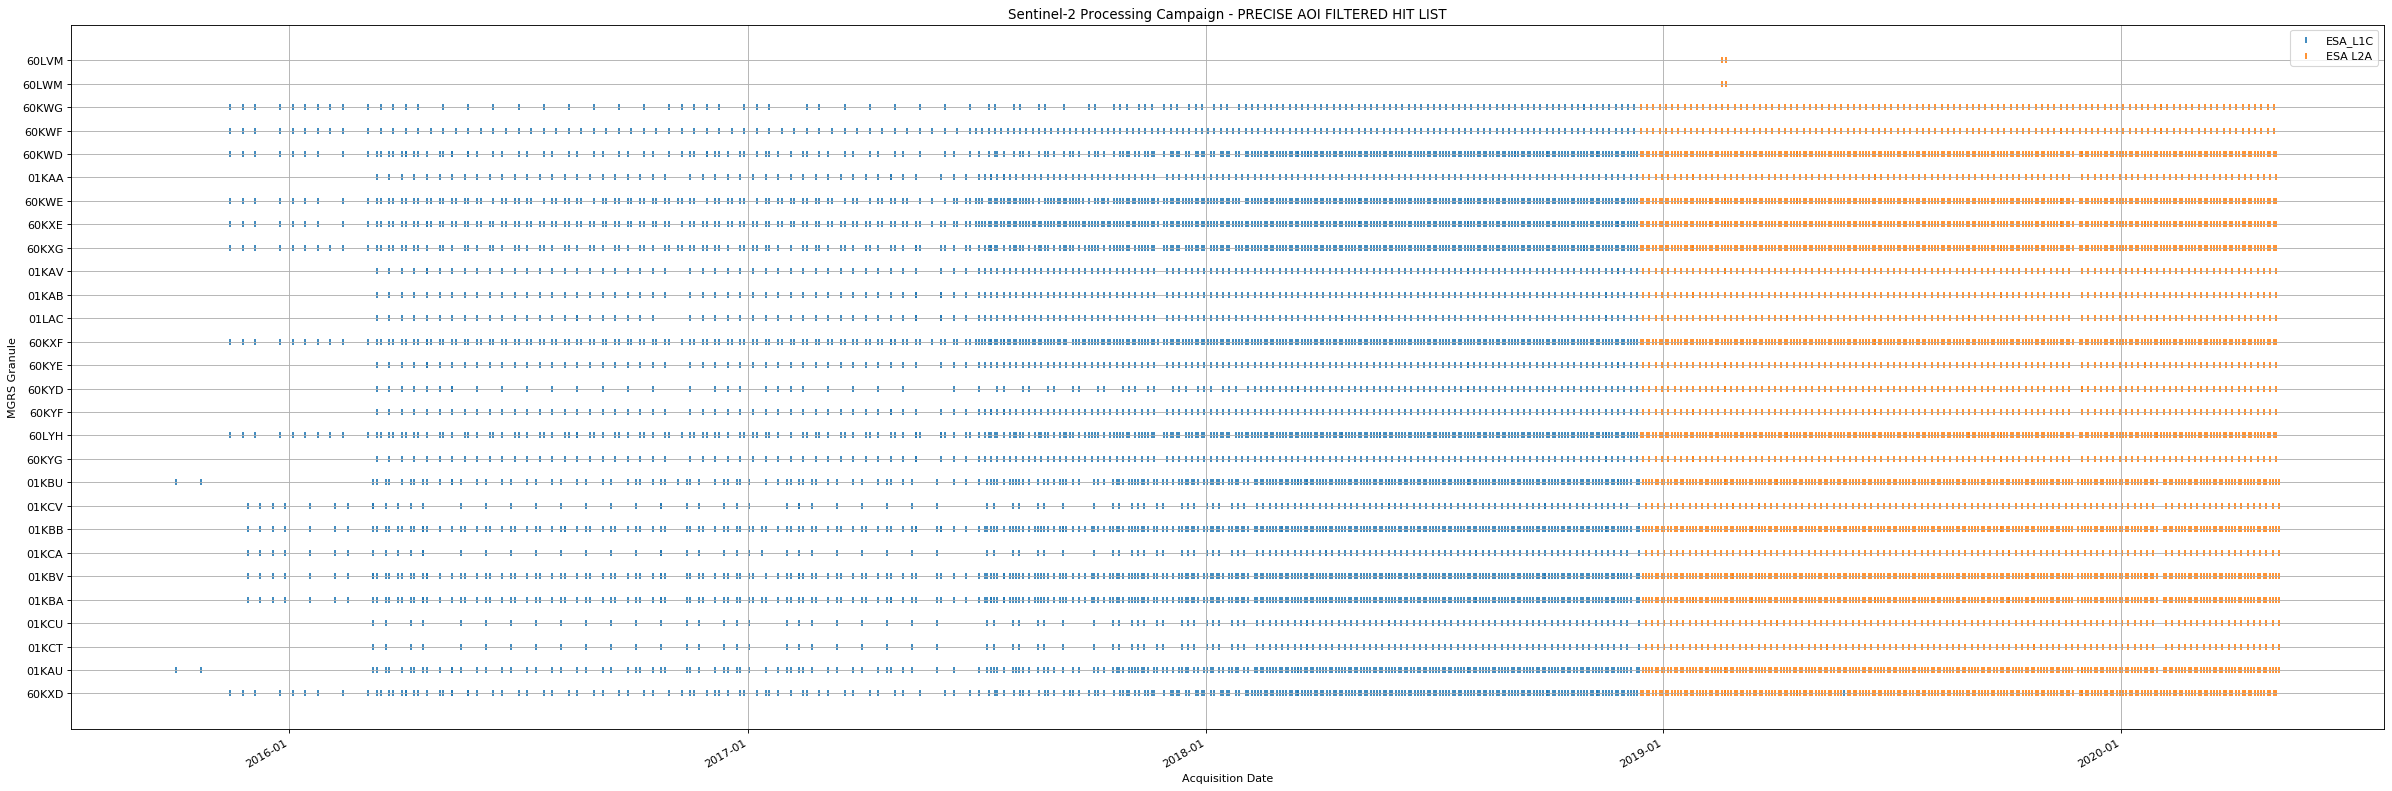

In [87]:
# Plot temporality of L1C and L2A
fig, ax = plt.subplots(figsize=(30,10),dpi=80)
fig.autofmt_xdate()

df = esa_l1c_precise
df['Acquisition Date'] = pd.to_datetime(df['beginposition'], format='%Y-%m-%d', utc=True)
#df = df[(df['Acquisition Date']>datetime.date(2019,1,1)) & (df['Acquisition Date']<datetime.date(2020,1,1))]
ax.scatter(df['Acquisition Date'].values, df['granules'].values, marker='|');

df = esa_l2a_precise
df['Acquisition Date'] = pd.to_datetime(df['beginposition'], format='%Y-%m-%d', utc=True)
#df = df[(df['Acquisition Date']>datetime.date(2019,1,1)) & (df['Acquisition Date']<datetime.date(2020,1,1))]
ax.scatter(df['Acquisition Date'].values, df['granules'].values, marker='|');

# df = gc_l1c_match
# df['Acquisition Date'] = pd.to_datetime(df['SENSING_TIME'], format='%Y-%m-%d', utc=True)
# df['granules'] = df['MGRS_TILE']
# # remove files showing as NaN size
# df = df.dropna(subset=['TOTAL_SIZE'])
# #df = df[(df['Acquisition Date']>datetime.date(2019,1,1)) & (df['Acquisition Date']<datetime.date(2020,1,1))]
# ax.scatter(df['Acquisition Date'].values, df['granules'].values, marker='_');

# df = gc_l2a_match
# df['Acquisition Date'] = pd.to_datetime(df['SENSING_TIME'], format='%Y-%m-%d', utc=True)
# df['granules'] = df['MGRS_TILE']
# # remove files showing as NaN size
# df = df.dropna(subset=['TOTAL_SIZE'])
# #df = df[(df['Acquisition Date']>datetime.date(2019,1,1)) & (df['Acquisition Date']<datetime.date(2020,1,1))]
# ax.scatter(df['Acquisition Date'].values, df['granules'].values, marker='|');

ax.set_ylabel('MGRS Granule');
ax.set_xlabel("Acquisition Date");
ax.legend(['ESA_L1C','ESA L2A','USGS_L4-5TM','USGS_L1-4MSS']);
ax.set_title("Sentinel-2 Processing Campaign - PRECISE AOI FILTERED HIT LIST");
ax.xaxis.set_major_locator(mdates.AutoDateLocator());
ax.xaxis.set_major_formatter(DateFormatter("%Y-%m") ); 
ax.grid(which='both')
fig.tight_layout()
#fig.savefig('../Search_Discovery/Fiji_S1_tempdistribution_orbitdirection');

### CROSS-CHECK AGAINST S3 BUCKET

In [88]:
s3_bucket = 'public-eo-data'
s3_dir = 'common_sensing/fiji/sentinel_2'

In [89]:
s3_paths = s3_list_objects_paths(s3_bucket, s3_dir)
yamls = [i for i in s3_paths if i.split('/')[-1][-4:] == 'yaml']

In [90]:
s3_nms = [i.split('/')[-2] for i in yamls]
esa_l2_nms = [i.replace('MSIL1C','MSIL2A') for i in esa_l2a_precise.scenename.values]
esa_l2a_precise['SAC_DONE'] = [ i in s3_nms for i in esa_l2_nms]
esa_l1_nms = [i.replace('MSIL1C','MSIL2A') for i in esa_l1c_precise.scenename.values]
esa_l1c_precise['SAC_DONE'] = [ i in s3_nms for i in esa_l1_nms]

esa_l2a_precise['SAC_DONE'].value_counts(), esa_l1c_precise['SAC_DONE'].value_counts()

(True     3807
 False     105
 Name: SAC_DONE, dtype: int64,
 False    5296
 Name: SAC_DONE, dtype: int64)

### CROSS-CHECK ESA AGAINST GCLOUD

In [91]:
esa_l1c_precise['GCLOUD_PRES'] = [i in gc_l1c_match.scenename.values  for i in esa_l1c_precise.scenename.values]
esa_l2a_precise['GCLOUD_PRES'] = [i in gc_l2a_match.scenename.values  for i in esa_l2a_precise.scenename.values]

esa_l2a_precise['GCLOUD_PRES'].value_counts(), esa_l1c_precise['GCLOUD_PRES'].value_counts()

(True     3890
 False      22
 Name: GCLOUD_PRES, dtype: int64,
 True     5097
 False     199
 Name: GCLOUD_PRES, dtype: int64)

In [92]:
# esa_l1c_precise['ESA_ONLINE'] = [ esa_api.get_product_odata(i)['Online'] for i in tqdm(esa_l1c_precise.uuid.values) ]
# esa_l2a_precise['ESA_ONLINE'] = [ esa_api.get_product_odata(i)['Online'] for i in tqdm(esa_l2a_precise.uuid.values) ]
# esa_l2a_precise['ESA_ONLINE'].value_counts(), esa_l1c_precise['ESA_ONLINE'].value_counts()

### SAVE DFS

In [93]:
td = datetime.today()
td = td.strftime('%Y')+td.strftime('%m')+td.strftime('%d')
cols = ['title','scenename','cloudcoverpercentage','platformname','Acquisition Date','granules','SAC_DONE','GCLOUD_PRES','uuid','geometry']

In [94]:
(f"{inter_dir}outputs/SD_{td}_{region_name}_S2_L2A.csv",
f"{inter_dir}outputs/SD_{td}_{region_name}_S2_L1C.csv",
 f"{inter_dir}outputs/SD_{td}_{region_name}_S1_GRD.csv",
f"{inter_dir}outputs/SD_{td}_{region_name}_LS_C1.csv",
f"{inter_dir}outputs/JOBLIST_{td}_{region_name}_S2_L2A.txt")

('/tmp/data/outputs/SD_20200506_Fiji_S2_L2A.csv',
 '/tmp/data/outputs/SD_20200506_Fiji_S2_L1C.csv',
 '/tmp/data/outputs/SD_20200506_Fiji_S1_GRD.csv',
 '/tmp/data/outputs/SD_20200506_Fiji_LS_C1.csv',
 '/tmp/data/outputs/JOBLIST_20200506_Fiji_S2_L2A.txt')

In [95]:
# save to L1 & L2 csvs
esa_l2a_precise[cols].to_csv(f"{inter_dir}outputs/SD_{td}_{region_name}_S2_L2A.csv")
esa_l1c_precise[cols].to_csv(f"{inter_dir}outputs/SD_{td}_{region_name}_S2_L1C.csv")

### CREATE JOBLIST

In [76]:
to_do_l1 = []
for s, p in zip(esa_l1c_precise.title.values, esa_l1c_precise.SAC_DONE):
    if not p:
        to_do_l1.append(s)
print(len(to_do_l1),to_do_l1[0])
to_do_l2 = []
for s, p in zip(esa_l2a_precise.title.values, esa_l2a_precise.SAC_DONE):
    if not p:
        to_do_l2.append(s)
print(len(to_do_l2),to_do_l2[0])

5296 S2A_MSIL1C_20190524T221941_N0207_R029_T60KXD_20190524T234151
38 S2B_MSIL2A_20200426T223009_N0214_R072_T60LYH_20200427T001444


In [90]:
with open(f"{inter_dir}outputs/JOBLIST_{td}_{region_name}_S2_L1C.txt", 'a') as t:
    for v in to_do_l1:
        t.write("rpush jobS2"+" '{"+'"in_scene": "'+ v +'", "s3_bucket": "public-eo-data", "s3_dir": "common_sensing/fiji/sentinel_2/"'+"}'" + '\n')

with open(f"{inter_dir}outputs/JOBLIST_{td}_{region_name}_S2_L2A.txt", 'a') as t:
    for v in to_do_l2:
        t.write("rpush jobS2"+" '{"+'"in_scene": "'+ v +'", "s3_bucket": "public-eo-data", "s3_dir": "common_sensing/fiji/sentinel_2/"'+"}'" + '\n')

# **SENTINEL-1**

## ESA QUERY

In [97]:
# Login to esa api
esa_api = SentinelAPI(os.environ['COPERNICUS_USERNAME'],os.environ['COPERNICUS_PWD'])

In [98]:
# ESA Query
res = esa_api.query(aoi_wkt,platformname='Sentinel-1',producttype='GRD',sensoroperationalmode='IW')
esa_grd = esa_api.to_geodataframe(res)



Querying products:  12%|█▏        | 100/827 [00:00<?, ? products/s]

Querying products:  24%|██▍       | 200/827 [00:03<00:24, 25.35 products/s]

Querying products:  36%|███▋      | 300/827 [00:08<00:22, 23.81 products/s]

Querying products:  48%|████▊     | 400/827 [00:14<00:19, 21.37 products/s]

Querying products:  60%|██████    | 500/827 [00:19<00:15, 21.53 products/s]

Querying products:  73%|███████▎  | 600/827 [00:23<00:10, 21.76 products/s]

Querying products:  85%|████████▍ | 700/827 [00:28<00:06, 21.09 products/s]

Querying products:  97%|█████████▋| 800/827 [00:33<00:01, 21.33 products/s]

Querying products: 100%|██████████| 827/827 [00:36<00:00, 22.60 products/s]


## ASF QUERY

In [99]:
asf_grd_matches = get_s1_asf_urls(esa_grd.title.values)

In [100]:
df = pd.merge(left=esa_grd, right=asf_grd_matches, how='left', left_on='title', right_on='Granule Name')

In [101]:
# Create bool for intersection between any tiles 
for n, g in zip(aoi.NAME, aoi.geometry):
    df[n] = df.geometry.apply(lambda x: gpd.GeoSeries(x).intersects(g))
# Filter based on any True intersections
df[region_name] = df[df[aoi.NAME.values]].any(1)
df_c = df[df[region_name]==True]

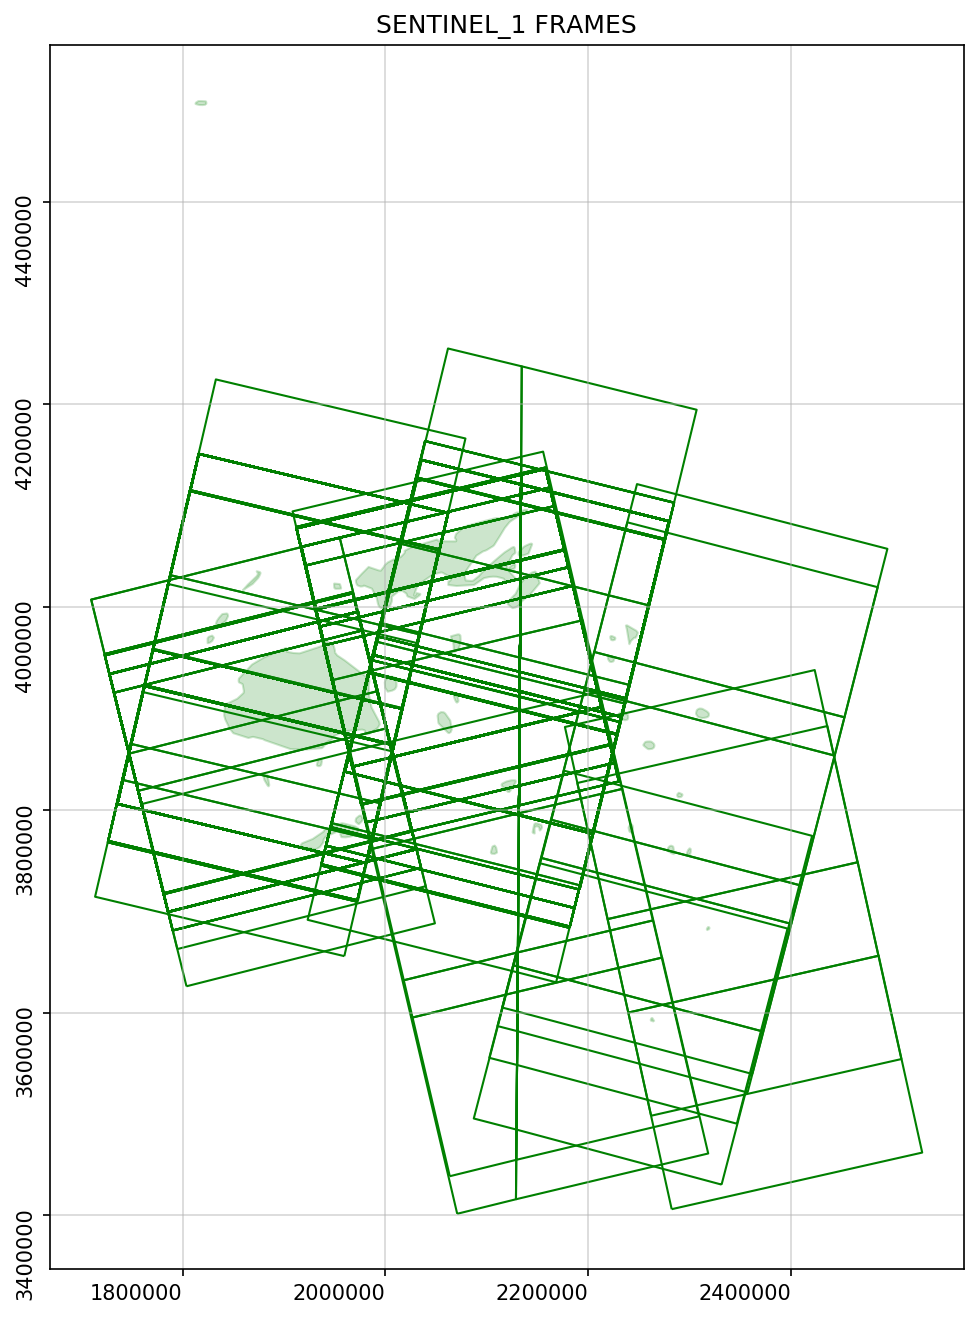

In [102]:
# Plot coverage
fig, ax = plt.subplots(figsize=(12,12),dpi=150)
fig.autofmt_xdate()
leg_patches=[]

x = aoi.to_crs(plot_crs).plot(facecolor="g", edgecolor='g', ax=ax, alpha=0.2);
leg_patches.append(mpatches.Patch(facecolor="g", edgecolor='g', alpha=0.25, lw=0.7, label=region_name))

df_c.to_crs(plot_crs).plot(facecolor='',edgecolor='g',ax=ax)

ax.set_title('SENTINEL_1 FRAMES')
ax.grid(alpha=0.5);
ax.tick_params(axis='y', rotation=90);
ax.tick_params(axis='x', rotation=0);

## ADDRESS ANTI_MERIDIAN NON-OVERLAP

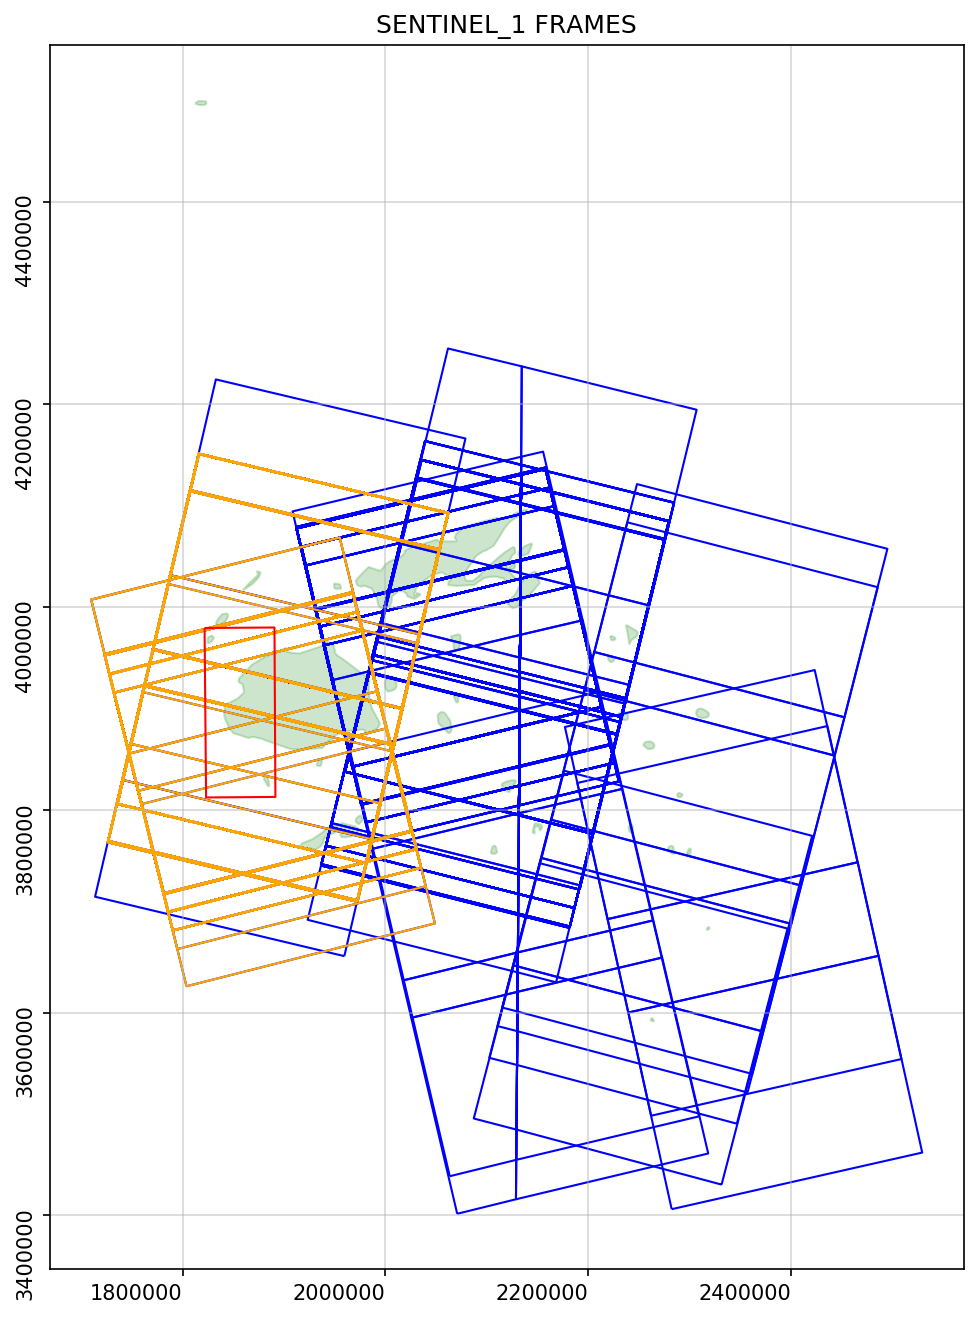

In [103]:
plot_crs = {"init": "epsg:3460"}

# select scenes over mainisland for product development
non_am = "POLYGON((177.07301550947307 -17.17940113068343,177.72120886884807 -17.17940113068343,177.72120886884807 -18.689732935559707,177.07301550947307 -18.689732935559707,177.07301550947307 -17.17940113068343))"
non_am = pd.DataFrame(data={'geometry': [non_am]})
non_am['geometry'] = non_am['geometry'].apply(wkt.loads)
non_am['NAME'] = 'SUB'
non_am = gpd.GeoDataFrame(non_am, geometry='geometry', crs=('epsg:4326'))
non_am.crs = from_epsg(4326)

# intersect non-am subset
non_am_fij = non_am.to_crs({"init": "epsg:3460"})
df_c['des'] = df_c.to_crs({"init": "epsg:3460"}).geometry.map(lambda x: x.intersects(non_am_fij.geometry.any())) # repro and test intersect
df_c_nonam = df_c[df_c['des']==True] # subset



# Plot coverage
fig, ax = plt.subplots(figsize=(12,12),dpi=150)
fig.autofmt_xdate()
leg_patches=[]

x = aoi.to_crs(plot_crs).plot(facecolor="g", edgecolor='g', ax=ax, alpha=0.2);
leg_patches.append(mpatches.Patch(facecolor="g", edgecolor='g', alpha=0.25, lw=0.7, label=region_name))

df_c.to_crs(plot_crs).plot(facecolor='',edgecolor='b',ax=ax)

df_c_nonam.to_crs(plot_crs).plot(facecolor='',edgecolor='orange',ax=ax)

non_am.to_crs(plot_crs).plot(facecolor='',edgecolor='r',ax=ax)

ax.set_title('SENTINEL_1 FRAMES')
ax.grid(alpha=0.5);
ax.tick_params(axis='y', rotation=90);
ax.tick_params(axis='x', rotation=0);

## CROSS-CHECK AGAINST S3 BUCKET

In [104]:
s3_bucket = 'public-eo-data'
s3_dir = 'common_sensing/fiji/sentinel_1/'

s3_paths = s3_list_objects_paths(s3_bucket, s3_dir)
yamls = [i for i in s3_paths if i.split('/')[-1][-4:] == 'yaml']

In [105]:
yamls[0].split('/')[-2]

'S1A_IW_GRDH_1SDV_20150507T063939'

In [106]:
df_c_nonam['SAC_DONE'] = [ i[:32] in [j.split('/')[-2] for j in yamls] for i in df_c_nonam.title.values ]

In [107]:
df_c_nonam['SAC_DONE'].value_counts()

True     286
False     97
Name: SAC_DONE, dtype: int64

In [108]:
to_do = []
for s, p in zip(df_c_nonam.title.values, df_c_nonam.SAC_DONE):
    if not p:
        to_do.append(s)
len(to_do),to_do[0]

(97, 'S1A_IW_GRDH_1SDV_20200504T064007_20200504T064042_032411_03C0C7_FE9D')

## CREATE JOBLIST

In [109]:
with open(f"{inter_dir}outputs/JOBLIST_{td}_{region_name}_S1_nonAM.txt", 'a') as t:
    
    for v in to_do:

        t.write("rpush jobS1"+" '{"+'"in_scene": "'+ v +'", "s3_bucket": "public-eo-data", "s3_dir": "common_sensing/fiji/sentinel_1/", "ext_dem": "common_sensing/ancillary_products/SRTM1Sec/SRTM30_Fiji_E.tif"'+"}'" + '\n')

# **LANDSAT**

In [248]:
# load world granules
world_granules = gpd.read_file(anc_paths['lstiles_path'][0])
# Create bool for intersection between any tiles - should try inversion to speed up...
for n, g in zip(aoi.NAME, aoi.geometry):
    world_granules[n] = world_granules.geometry.apply(lambda x: gpd.GeoSeries(x).intersects(g))
# Filter based on any True intersections
world_granules[region_name] = world_granules[world_granules[aoi.NAME.values]].any(1)
region_ls_grans = world_granules[world_granules[region_name]==True]

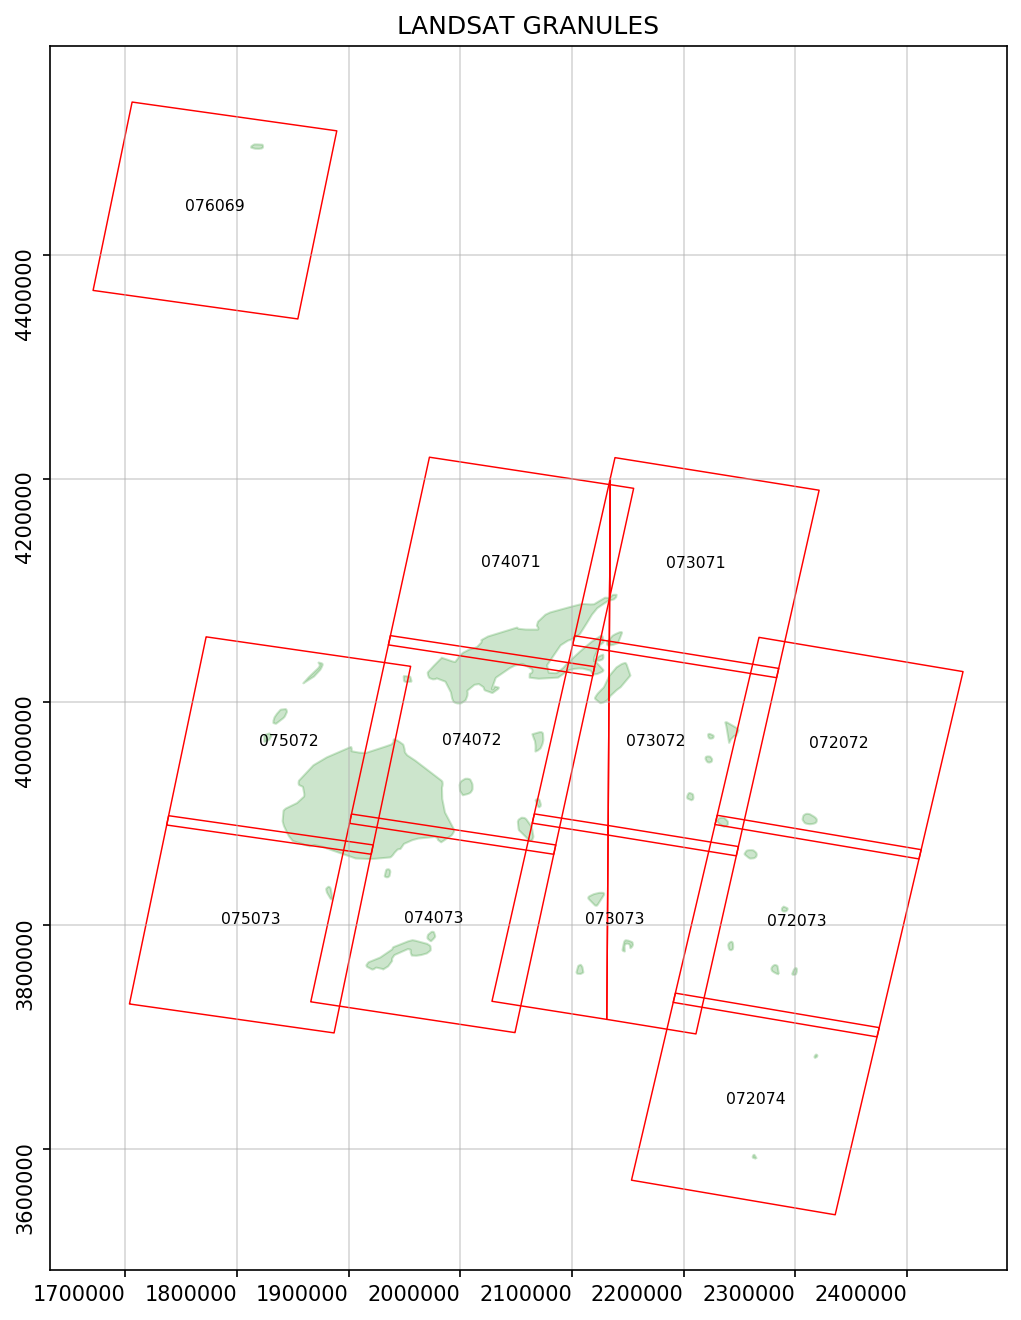

In [252]:
# Plot coverage
fig, ax = plt.subplots(figsize=(12,12),dpi=150)
fig.autofmt_xdate()
leg_patches=[]

x = aoi.to_crs(plot_crs).plot(facecolor="g", edgecolor='g', ax=ax, alpha=0.2);
leg_patches.append(mpatches.Patch(facecolor="g", edgecolor='g', alpha=0.25, lw=0.7, label=region_name))

x = region_ls_grans.to_crs(plot_crs).plot(facecolor="none", edgecolor='r', lw=0.7, ax=ax)
leg_patches.append(mpatches.Patch(facecolor="none", edgecolor='r', lw=0.7, label='Sentinel-2 Tiles'))
region_ls_grans.to_crs(plot_crs).apply(lambda x: ax.annotate(s=x.PR, xy=x.geometry.centroid.coords[0], ha='center', fontsize=7.5),axis=1)

ax.set_title('LANDSAT GRANULES')
ax.grid(alpha=0.5);
ax.tick_params(axis='y', rotation=90);
ax.tick_params(axis='x', rotation=0);

In [254]:
pr = region_ls_grans
df = pd.read_csv(anc_paths['ls8csv_path'][0]) # latest csv can be found at - https://www.usgs.gov/land-resources/nli/landsat/bulk-metadata-service
df = df[df.row.isin(pr.ROW.values)&df.path.isin(pr.PATH.values)]
res3 = df
df = None

In [257]:
df = pd.read_csv(anc_paths['ls7csv_path'][0]) # latest csv can be found at - https://www.usgs.gov/land-resources/nli/landsat/bulk-metadata-service
df = df[df.row.isin(pr.ROW.values)&df.path.isin(pr.PATH.values)]
res2 = df
df = None

EmptyDataError: No columns to parse from file

In [258]:
# pr = country_ls_grans
df = pd.read_csv(anc_paths['ls45csv_path'][0]) # latest csv can be found at - https://www.usgs.gov/land-resources/nli/landsat/bulk-metadata-service
df = df[df.row.isin(pr.ROW.values)&df.path.isin(pr.PATH.values)]
res1 = df
df = None

In [259]:
res3.shape

(2562, 59)

In [300]:
l8_list = list(res3.LANDSAT_PRODUCT_ID.values)

In [413]:
# function for basic interaction with ESPA API - hacked together from their 'how to page'
def espa_api(endpoint, verb='get', body=None, uauth=None):
    """ Suggested simple way to interact with the ESPA JSON REST API """
    auth_tup = uauth if uauth else (username, password)
    response = getattr(requests, verb)(host + endpoint, auth=auth_tup, json=body)
    print('{} {}'.format(response.status_code, response.reason))
    data = response.json()
    if isinstance(data, dict):
        messages = data.pop("messages", None)  
        if messages:
            print(json.dumps(messages, indent=4))
    try:
        response.raise_for_status()
    except Exception as e:
        print(e)
        return None
    else:
        return data

In [416]:
# earth explorer credentials are required
host = 'https://espa.cr.usgs.gov/api/v1/'
#username = 'tom.jones'
#password = 'Welcome12'
username = 'sarah.cheesbrough'
password = 'SaCh_SatApps_USGS1'
# check login
print('GET /api/v1/user')
resp = espa_api('user')
print(json.dumps(resp, indent=4))

GET /api/v1/user
200 OK
{
    "email": "Sarah.Cheesbrough@sa.catapult.org.uk",
    "first_name": "Sarah",
    "last_name": "Cheesbrough",
    "roles": [
        "active"
    ],
    "username": "sarah.cheesbrough"
}


In [417]:
## CHECK CONFLICTING ORDERS ###

# check for any existing orders that may prevent imediate processing of a fresh requestttttt
print('GET /api/v1/list-orders')
filters = {"status": ["complete", "ordered"]}  # Here, we ignore any purged orders
resp = espa_api('list-orders', body=filters)
print(json.dumps(resp, indent=4))

GET /api/v1/list-orders
200 OK
[
    "espa-Sarah.Cheesbrough@sa.catapult.org.uk-10252019-080031-821",
    "espa-Sarah.Cheesbrough@sa.catapult.org.uk-10252019-061742-988",
    "espa-Sarah.Cheesbrough@sa.catapult.org.uk-10252019-061537-204",
    "espa-Sarah.Cheesbrough@sa.catapult.org.uk-10252019-061023-761",
    "espa-Sarah.Cheesbrough@sa.catapult.org.uk-10252019-060110-664",
    "espa-Sarah.Cheesbrough@sa.catapult.org.uk-10252019-080959-437",
    "espa-Sarah.Cheesbrough@sa.catapult.org.uk-10252019-080506-662",
    "espa-Sarah.Cheesbrough@sa.catapult.org.uk-10252019-080423-123",
    "espa-Sarah.Cheesbrough@sa.catapult.org.uk-10252019-080244-635",
    "espa-Sarah.Cheesbrough@sa.catapult.org.uk-10252019-053952-070"
]


In [331]:
### CHECK PRODUCT AVAILABILITY ###

# example of how to check available products for desired scenes
print('GET /api/v1/available-products')
avail_list = {'inputs': l8_list
             }
resp = espa_api('available-products', body=avail_list)
print(json.dumps(resp, indent=4))

GET /api/v1/available-products
200 OK
{
    "olitirs8_collection": {
        "inputs": [
            "LC08_L1GT_076069_20190924_20190925_01_RT",
            "LC08_L1GT_076071_20190924_20190925_01_RT",
            "LC08_L1GT_073069_20190919_20190920_01_RT",
            "LC08_L1TP_073071_20190919_20190920_01_RT",
            "LC08_L1TP_073072_20190919_20190920_01_RT",
            "LC08_L1TP_073073_20190919_20190920_01_RT",
            "LC08_L1GT_075069_20190917_20190918_01_RT",
            "LC08_L1GT_075071_20190917_20190918_01_RT",
            "LC08_L1TP_075072_20190917_20190918_01_RT",
            "LC08_L1TP_075073_20190917_20190918_01_RT",
            "LC08_L1GT_072069_20190912_20190917_01_T2",
            "LC08_L1GT_072071_20190912_20190917_01_T2",
            "LC08_L1TP_072072_20190912_20190917_01_T2",
            "LC08_L1TP_072073_20190912_20190917_01_T1",
            "LC08_L1GT_072074_20190912_20190917_01_T2",
            "LC08_L1GT_074069_20190910_20190917_01_T2",
            "LC

In [313]:
l8_list = list(res3.LANDSAT_PRODUCT_ID.values)
print(len(l8_list))
er = set(["LC08_L1GT_072069_20160224_20170329_01_T2",
            "LC08_L1GT_072071_20160224_20170329_01_T2",
            "LC08_L1GT_072072_20160224_20170329_01_T2",
            "LC08_L1TP_072073_20160224_20170329_01_T1",
            "LC08_L1GT_072074_20160224_20170329_01_T2",
            "LC08_L1GT_074069_20160222_20170329_01_T2",
            "LC08_L1GT_074071_20160222_20170329_01_T2",
            "LC08_L1TP_074072_20160222_20170329_01_T1",
            "LC08_L1TP_074073_20160222_20170329_01_T1",
            "LC08_L1TP_076069_20160220_20180202_01_T1"])
#er = ['LC08_L1TP_166051_20190814_20190814_01_RT', 'LC08_L1TP_166048_20190814_20190814_01_RT']
ls = l8_list
#ls = [x (if x is not in er) for x in l8_list]
for i in er: 
    print(i)
    ls.remove(er)
print(len(ls))

2545
LC08_L1TP_076069_20160220_20180202_01_T1


ValueError: list.remove(x): x not in list

In [324]:
### CREATE ORDER ###
# if any further subsetting is required. very recently acquired products are categorised as RT (as opposed to T1/T2). these are of insufficient certainty RE quality to be processed to ARD. this latency is unlikely to impact the non-NRT requirements of Common Sensing.
er = ['LC08_L1GT_072069_20160224_20170329_01_T2', 
      'LC08_L1GT_072071_20160224_20170329_01_T2', 
      'LC08_L1GT_072072_20160224_20170329_01_T2', 
      'LC08_L1TP_072073_20160224_20170329_01_T1', 
      'LC08_L1GT_072074_20160224_20170329_01_T2', 
      'LC08_L1GT_074069_20160222_20170329_01_T2', 
      'LC08_L1GT_074071_20160222_20170329_01_T2', 
      'LC08_L1TP_074072_20160222_20170329_01_T1', 
      'LC08_L1TP_074073_20160222_20170329_01_T1', 
      'LC08_L1TP_076069_20160220_20180202_01_T1'
     ]
#er = ['LC08_L1TP_166051_20190814_20190814_01_RT', 'LC08_L1TP_166048_20190814_20190814_01_RT']
l8_ls = [e for e in l8_list if e not in (er)]
l8_ls = [i for i in l8_list if 'RT' not in i]

# specifying differing products across the sensors
l8_prods = ["sr","bt","source_metadata","sr_ndvi","sr_evi","sr_savi","sr_msavi","sr_ndmi","sr_nbr","sr_nbr2","stats","pixel_qa"]
         
# determine available-products under their respective sensors
ls = l8_ls
print('GET /api/v1/available-products')
order = espa_api('available-products', body=dict(inputs=ls))
print(json.dumps(order, indent=4))

# replace available products with what we wish to process
for sensor in order.keys():
    if isinstance(order[sensor], dict) and order[sensor].get('inputs'):

        if set(l8_ls) & set(order[sensor]['inputs']):
            order[sensor]['products'] = l8_prods

# Add in the rest of the order information
#order['projection'] = projection
order['format'] = 'gtiff'
order['resampling_method'] = 'cc'
order['note'] = 'DY Veg'

# the order shoud now have changed from the original call available-products
print(json.dumps(order, indent=4))

GET /api/v1/available-products
200 OK
{
    "olitirs8_collection": {
        "inputs": [
            "LC08_L1GT_072069_20190912_20190917_01_T2",
            "LC08_L1GT_072071_20190912_20190917_01_T2",
            "LC08_L1TP_072072_20190912_20190917_01_T2",
            "LC08_L1TP_072073_20190912_20190917_01_T1",
            "LC08_L1GT_072074_20190912_20190917_01_T2",
            "LC08_L1GT_074069_20190910_20190917_01_T2",
            "LC08_L1TP_074071_20190910_20190917_01_T1",
            "LC08_L1TP_074072_20190910_20190917_01_T1",
            "LC08_L1TP_074073_20190910_20190917_01_T1",
            "LC08_L1GT_076069_20190908_20190917_01_T2",
            "LC08_L1GT_076071_20190908_20190917_01_T2",
            "LC08_L1GT_073069_20190903_20190917_01_T2",
            "LC08_L1GT_073071_20190903_20190917_01_T2",
            "LC08_L1GT_073072_20190903_20190917_01_T2",
            "LC08_L1GT_073073_20190903_20190917_01_T2",
            "LC08_L1GT_075069_20190901_20190916_01_T2",
            "LC

In [325]:
order['date_restricted']

{'sr_ndmi': ['LC08_L1GT_072069_20160224_20170329_01_T2',
  'LC08_L1GT_072071_20160224_20170329_01_T2',
  'LC08_L1GT_072072_20160224_20170329_01_T2',
  'LC08_L1TP_072073_20160224_20170329_01_T1',
  'LC08_L1GT_072074_20160224_20170329_01_T2',
  'LC08_L1GT_074069_20160222_20170329_01_T2',
  'LC08_L1GT_074071_20160222_20170329_01_T2',
  'LC08_L1TP_074072_20160222_20170329_01_T1',
  'LC08_L1TP_074073_20160222_20170329_01_T1',
  'LC08_L1TP_076069_20160220_20180202_01_T1'],
 'sr_savi': ['LC08_L1GT_072069_20160224_20170329_01_T2',
  'LC08_L1GT_072071_20160224_20170329_01_T2',
  'LC08_L1GT_072072_20160224_20170329_01_T2',
  'LC08_L1TP_072073_20160224_20170329_01_T1',
  'LC08_L1GT_072074_20160224_20170329_01_T2',
  'LC08_L1GT_074069_20160222_20170329_01_T2',
  'LC08_L1GT_074071_20160222_20170329_01_T2',
  'LC08_L1TP_074072_20160222_20170329_01_T1',
  'LC08_L1TP_074073_20160222_20170329_01_T1',
  'LC08_L1TP_076069_20160220_20180202_01_T1'],
 'sr': ['LC08_L1GT_072069_20160224_20170329_01_T2',
  'L

In [326]:
order.keys()
order.pop('date_restricted')
order.pop('oli8_collection')

{'inputs': ['LO08_L1GT_075069_20150210_20170413_01_T2',
  'LO08_L1GT_075071_20150210_20170413_01_T2',
  'LO08_L1TP_075072_20150210_20170413_01_T1',
  'LO08_L1TP_075073_20150210_20170413_01_T1'],
 'products': ['sr',
  'bt',
  'source_metadata',
  'sr_ndvi',
  'sr_evi',
  'sr_savi',
  'sr_msavi',
  'sr_ndmi',
  'sr_nbr',
  'sr_nbr2',
  'stats',
  'pixel_qa']}

In [327]:
### PLACE ORDER ###
print('POST /api/v1/order')
resp = espa_api('order', verb='post', body=order)
print(resp.keys)
print(json.dumps(resp, indent=4))

POST /api/v1/order
400 BAD REQUEST
{
    "errors": [
        {
            "8 validation errors": [
                "Requested sr_ndmi products are restricted by date. Remove olitirs8_collection scenes: [u'LC08_L1GT_072069_20160224_20170329_01_T2', u'LC08_L1GT_072071_20160224_20170329_01_T2', u'LC08_L1GT_072072_20160224_20170329_01_T2', u'LC08_L1TP_072073_20160224_20170329_01_T1', u'LC08_L1GT_072074_20160224_20170329_01_T2', u'LC08_L1GT_074069_20160222_20170329_01_T2', u'LC08_L1GT_074071_20160222_20170329_01_T2', u'LC08_L1TP_074072_20160222_20170329_01_T1', u'LC08_L1TP_074073_20160222_20170329_01_T1', u'LC08_L1TP_076069_20160220_20180202_01_T1']",
                "Requested sr_savi products are restricted by date. Remove olitirs8_collection scenes: [u'LC08_L1GT_072069_20160224_20170329_01_T2', u'LC08_L1GT_072071_20160224_20170329_01_T2', u'LC08_L1GT_072072_20160224_20170329_01_T2', u'LC08_L1TP_072073_20160224_20170329_01_T1', u'LC08_L1GT_072074_20160224_20170329_01_T2', u'LC08_L1GT_074

AttributeError: 'NoneType' object has no attribute 'keys'